In [24]:
from grid_world import negative_grid, standard_grid
from iterative_policy_evaluation import print_values, print_policy 
import numpy as np 
from matplotlib import pyplot as plt 

In [3]:
# define an episode of the game 

GAMMA = 0.9 
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
grid = negative_grid(step_cost = -0.9)

def play_game(policy, grid): 
    '''
    plays one episode of the grid world game 
    returns: a state, action, return triplet of the game 
    '''
    
    # random initialize starting state and action 
    starting_states = list(grid.actions.keys()) 
    starting_index = np.random.choice(len(starting_states))
    state = starting_states[starting_index]
    action = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
    # set grid to current state 
    grid.set_state(state)
    seen_states = set()
    seen_states.add(grid.current_state())
    
    # append starting state, action and return 0 since starting state doesn't generate any reward 
    # as r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [(state, action, 0)]
    
    # i.e. we start in state: state and perform action and will then get some reward 
    num_steps = 0 
    while True: 
        # perform the action and cache the resulting reward given action: action 
        reward = grid.move(action) 
        
        # the state we end up in due to action: action 
        state = grid.current_state() 
        
        # increment num_steps 
        num_steps += 1 
        
        # check of we ended up in the same state
        if state in seen_states: 
            # if we bumped into a wall the reward is set to -10 and we end the episode 
            # append the action None as we shouldn't perform an action in a terminal state 
            reward = -10 / num_steps 
            states_actions_rewards.append((state, None, reward))
            break 
            
        # the next conditional checks if the game is over 
        elif grid.game_over(): 
            # append the state, action, reward triple and break out of the while-statement  
            states_actions_rewards.append((state, None, reward))
            break 
            
        # else we continue playing, choose an action given the state
        # append the state, action, reward triplet i.e. 
        # being in state s(t), performing action a(t) and getting the reward r(t + 1)
        else:
            action = policy[state]
            states_actions_rewards.append((state, action, reward))
            
        seen_states.add(state)
        
    # when the while-statement is finished we need to calculate the return for each visited state 
    # we need to do this so that the terminal state has zero return
    
    first = True 
    states_actions_returns = []
    G = 0 
    for state, action, reward in reversed(states_actions_rewards): 
        if first: 
            # we encounter the terminal state - set first to false 
            first = False
        else: 
            # we should add the state, action, return triple 
            states_actions_returns.append((state, action, G))
            
        # G is updated as r(t + 1) + GAMMA * G(t + 1)
        G = reward + GAMMA * G
    
    states_actions_returns.reverse()
    return states_actions_returns
        

In [5]:
# print rewards 

print_values(grid.rewards, grid)

---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [34]:
# initialize pi at random 
import operator 
policy = {}
for state in grid.actions: 
    policy[state] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
# initialize Q and returns 
returns = {}
Q = {}

for state in grid.all_states(): 
    if state in grid.actions: 
        Q[state] = {}
        for action in ALL_POSSIBLE_ACTIONS: 
            Q[state][action] = 0
            returns[(state, action)] = []
            
# repeat 
deltas = list()
for _ in range(10000):
    states_actions_returns = play_game(policy, grid)
    
    # to cope with first-visit monte carlo approach 
    seen_pairs = set()
    delta = 0
    for state, action, G in states_actions_returns: 
        if (state, action) not in seen_pairs: 
            returns[(state, action)].append(G)
            old_action_value = Q[state][action]
            Q[state][action] = np.mean(returns[(state, action)])
            change = max(delta, np.abs(Q[state][action] - old_action_value))
            seen_pairs.add((state, action))
    deltas.append(change)
    
    for state in grid.actions: 
        policy[state] = max(Q[state].items(), key=operator.itemgetter(1))[0]
        
print_policy(policy, grid)

---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


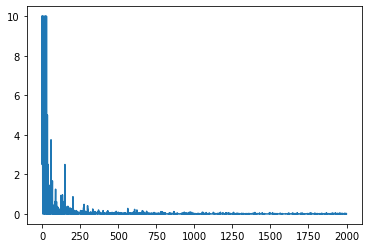

In [29]:
plt.plot(deltas)

In [35]:
V = {}
for k, v in Q.items():
    max_key = max(v.items(), key=operator.itemgetter(1))[0]
    V[k] = v[max_key]
    
print_values(V, grid)

---------------------------
-0.34|-0.11| 1.00| 0.00|
---------------------------
-0.63| 0.00|-0.25| 0.00|
---------------------------
-1.20|-1.08|-0.57|-0.98|
